# Solving Max-Cut problem using Dwave Quantum Annealing
This notebook presents how to solve the NP-hard problem Max-Cut using Quantum Annealing.
In Quantum Annealing, we specify a Quadratic Uncontrained Binary Optimization (QUBO) model that is implemented as the final Hamiltonian in an plausible adiabatic evolution.
A QUBO can be expressed as
$$ \min_x \sum_{i,j}^n Q_{ij}x_i x_j + \sum_{i}^n Q_{ii} x_i, x \in \{0,1\}^n
$$

where we minimize an quadratic expression with respect to an $n$-dimensional vector of binary variables $\bf{x}$, the matrix $Q$ determines the quadratic and linear part of the QUBO. Notice that in this case we separate the elements of the diagonal of $Q$ given the fact that $x_i^2 = x_i, x_i \in \{0,1\}$. We can define a graph $G = (V,E)$ such that we have a vertex for every binary variable and include an edge for each non-zero term in $Q$ (technically speaking the boolean matrix of $Q$ is the adjacency matrix of $G$).
Besides the many applications of this formalism, solving a general QUBO is NP-hard.


This QUBO can be easily transformed to a well-studies problem in Physics, the Ising model. In the Ising model, we represent the energy of paramagnetic materials by assuming that each particle of the system $i$ has a corresponding spin (measured along the $Z$ axis) $\sigma_i^Z \in \{+1,-1\}$. These particles interact with their immediate neighbors in a graph $G = (V,E)$ and are subject to an external magnetic field that interacts with each particle by accounting for an energy $\pm h_i$. The interaction with other particles can lead to an increase of the total energy if their spins are oriented in the same direction ($J_{ij} > 0$, ferromagnetic), or in the opposite direction ($J_{ij} < 0$, antiferromagnetic). The function that accounts for the total energy of the system is known as the Hamiltonian $H_f$.
$$  H_f = \sum_{(ij) \in E}J_{ij}\sigma_i^Z \sigma_j^Z + \sum_{i \in V} h_i \sigma_i^Z
$$

Using the transformation $\sigma_i^Z = 1 - 2x_i$ and the corresponding tranformations for the matrices $Q$ and $J$ and vector $h$ we obtain the Hamiltonian from the original QUBO .

The Dwave devices start from an initial Hamiltonian $H_i$ and drive a time evolution to the final Hamiltonian $H_f$ slowly enough such that at every time step, represented by the adimensional time $s=t/T$ where $T$ is the total time, the system remains at its ground state, minimizing its energy. The energy of the system is described then as 
$$ H(s) = A(s)H_i + B(s)H_f
$$

Where $A(s)$ and $B(s)$ are time functions such that $A(0)=B(1)=1$ and $A(1)=B(0)=0$ (in practice we just need $A(0)/B(0) >> 1$ and $B(1)/A(1) >> 1$).

Usually the initial Hamiltonian is defined such that its ground state is a total superposition, and the usual choice is having
$$ H_i = \sum_{i=1}^n \sigma_i^X
$$

This procedure allows that at the end of the annealing procedure $s=1$, the ground state of $H_f$ is obtained. If that is the case and $H_f$ represents our $(QUBO)$ we would solve the optimization problem. Quantum Annealing offers an analog implementation of this algorithm, and uses niobium superconducting quantum interference device (SQUID) to implement the spins as qubits. Practically speaking, the Quantum Annealing can be considered as a metaheuristic for solving combinatorial optimization problems by translating them into constrained Ising problems. Whether this method actually takes advantage of quantum mechanics is still debated.

## Max-cut
The Max-cut problem, which is a combinatorial optimization problem deals with finding the largest cut of a graph $G = (V,E)$, where each edge has a weight $w_{ij}, \forall (ij) \in E$. The cut of a graph is defined as a separation of the vertices of the graph, and its value is the sum of the edges weights that are crossed by the cut.

A simple formulation of this problem can be proposed using binary variables $s_i \in \{+1,-1\}, \forall i \in V$ that represent whether each vertex belong to one side ($V^+$) or the other ($V^-$) of the cut.
In that case, to maximize the cut's value we maximize the number of edges that connect the two set of vertices $\delta(V^+)$.
$$ C = \sum_{(i,j) \in \delta(V^+)} (-1)w_{ij}s_i s_j
$$
where we include the term $s_i s_j$ that is $-1$ if the cut crosses the edge between $V^+$ and $V^-$ times a sign correction.
Since there is no way that we can know the set $\delta(V^+)$ a priori, we add the weights times the spins for all edges in the graph.
$$ \sum_{(i,j) \in E} w_{ij}s_i s_j = \\
\qquad \sum_{(i,j) \in E(V^+)}w_{ij} + \sum_{(i,j) \in E(V^+)}w_{ij} - \sum_{(i,j) \in \delta(V^+)} w_{ij}s_i s_j = \\
\qquad \qquad \sum_{(i,j) \in E}w_{ij} - 2\sum_{(i,j) \in \delta(V^+)} w_{ij}s_i s_j
$$
There is and offset given by the weights of the edges belonging to the same set. Writing the full optimization problem we have:
$$ C_{max} = \max_{\bf{s} \in \{+1,-1\}^n} \frac{1}{2} \sum_{(i,j) \in E} w_{ij}(1 - s_i s_j) = \\
\qquad \frac{1}{2} \left( \sum_{(i,j) \in E} w_{ij} + \min_{\bf{s} \in \{+1,-1\}^n}  \sum_{(i,j) \in E} w_{ij}s_i s_j \right)
$$

From the description above, we can observe that the Max-cut has a direct relationship with the Ising model. In this case, there is no external field $h$ and the coefficients of $J$ are the weights of the given graph.
Now we can solve the Max-cut problem via the Ising model.

In [1]:
import networkx as nx
import dimod
import neal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import timeit
import dwave_networkx as dnx
# import find_embedding
import minorminer as mm

In [2]:
# Define exact solver for small cases
exact_sampler = dimod.reference.samplers.ExactSolver()
# Simmulated annealing code (this will be considered the "simulator")
sim_ann = neal.SimulatedAnnealingSampler()
# Dwave device
from dwave.system.composites import EmbeddingComposite
from dwave.system.samplers import DWaveSampler
sampler = EmbeddingComposite(DWaveSampler())

### First example
Degree 2 graph (famous because was first instance that Fhari worked with for QAOA)

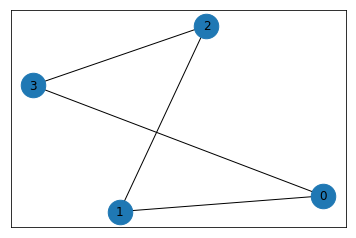

In [3]:
E1     =[(0,1,1.0),(1,2,1.0),(2,3,1.0),(3,0,1.0)] 

G1     = nx.Graph()
G1.add_weighted_edges_from(E1)

# Generate plot of the Graph
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G1)

nx.draw_networkx(G1, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [4]:
# Define Ising problem parameters
def ising_maxcut(G):
    '''
    G is a NetworkX graph
    '''
    h = {v: 0. for v in G.nodes()}
    if nx.is_weighted(G):
        J = {(u, v): 0.5*G[u][v]['weight'] for u, v in G.edges}
        offset = -0.5*sum(G[u][v]['weight'] for u, v in G.edges)
    else:
        J = {(u, v): 0.5 for u, v in G.edges}
        offset = -0.5*sum(1.0 for u, v in G.edges)
    
    bqm = dimod.BinaryQuadraticModel.from_ising(h, J, offset=offset)
    return bqm

In [5]:
# Plot all solutions profile
def plot_ennumerate(results):
    results.change_vartype(dimod.BINARY, inplace=True)
    samples = [''.join(c for c in str(datum.sample.values()).strip(', ') if c.isdigit()) for datum in results.data(['sample'],sorted_by=None)]
    
    energies = [-datum.energy for datum in results.data(['energy'],sorted_by=None)]

    plt.figure()
    plt.bar(samples,energies)
    plt.xticks(rotation=80)
    plt.xlabel('bitstring for solution')
    plt.ylabel('C (cut energy)')
    plt.show()

In [6]:
# Plot solutions profile
def plot_samples(results):
    results.change_vartype(dimod.BINARY, inplace=True)
    samples = [''.join(c for c in str(datum.sample.values()).strip(', ') if c.isdigit()) for datum in results.data(['sample'],sorted_by=None)]
    
    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    plt.figure()
    df.plot(kind='bar',legend=None)

    plt.xticks(rotation=80)
    plt.xlabel('bitstring for solution')
    plt.ylabel('Probabilities')
    plt.show()

In [7]:
# Plot energies profile
def plot_energies(results):
    results.change_vartype(dimod.BINARY, inplace=True)
    energies = [-datum.energy for datum in results.data(['energy'],sorted_by=None)]

    counts = Counter(energies)
    total = len(energies)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    plt.figure()
    df.plot(kind='bar',legend=None)

    plt.xlabel('C (cut energy)')
    plt.ylabel('Probabilities')
    plt.show()

The time it takes the enumeration of all solutions was 0.0023116999991543707 seconds


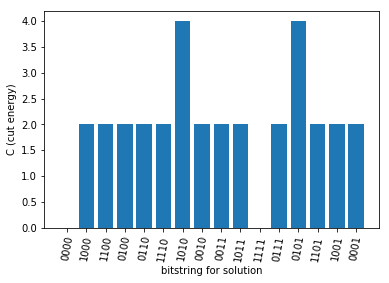

In [44]:
bqm = ising_maxcut(G1)
start_time = timeit.default_timer()
results_exact = exact_sampler.sample(bqm)
time_exact = timeit.default_timer() - start_time
print("The time it takes the enumeration of all solutions was "+str(time_exact)+" seconds")
plot_ennumerate(results_exact)

The time it took 2048 runs of simmulated annealing was 0.11512870000024122 seconds


<Figure size 432x288 with 0 Axes>

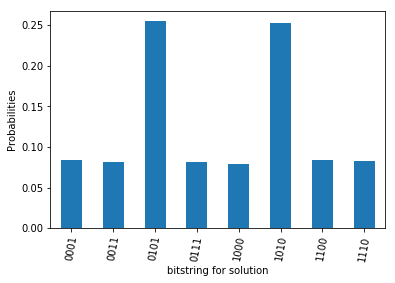

<Figure size 432x288 with 0 Axes>

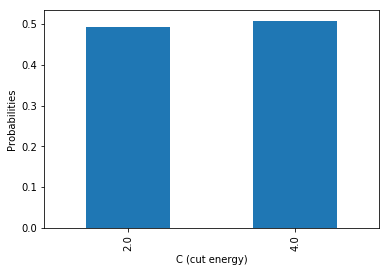

In [45]:
start_time = timeit.default_timer()
results_simann = sim_ann.sample(bqm, num_reads=2048)
time_simann = timeit.default_timer() - start_time
print("The time it took 2048 runs of simmulated annealing was "+str(time_simann)+" seconds")
plot_samples(results_simann)
plot_energies(results_simann)

In [46]:
start_time = timeit.default_timer()
results_dwave = sampler.sample(bqm, num_reads=2048)
time_dwave = timeit.default_timer() - start_time

In [47]:
print("The total time it took 2048 runs of quantum annealing was "+str(time_dwave)+" seconds")
time_dwave_detailed = results_dwave.info["timing"]
for key, value in time_dwave_detailed.items():
    print(str(key) + ' = ' + str(value/1000000) + " seconds")

The total time it took 2048 runs of quantum annealing was 2.440167300000212 seconds
qpu_sampling_time = 0.645038 seconds
qpu_anneal_time_per_sample = 2e-05 seconds
qpu_readout_time_per_sample = 0.000274 seconds
qpu_access_time = 0.654444 seconds
qpu_access_overhead_time = 0.002821 seconds
qpu_programming_time = 0.009406 seconds
qpu_delay_time_per_sample = 2.1e-05 seconds
total_post_processing_time = 0.002307 seconds
post_processing_overhead_time = 0.000967 seconds
total_real_time = 0.654444 seconds
run_time_chip = 0.645038 seconds
anneal_time_per_run = 2e-05 seconds
readout_time_per_run = 0.000274 seconds


<Figure size 432x288 with 0 Axes>

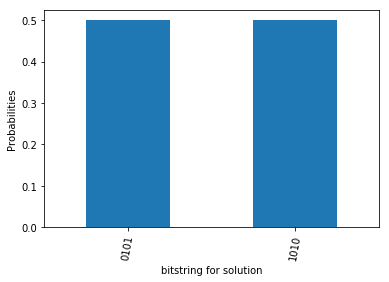

<Figure size 432x288 with 0 Axes>

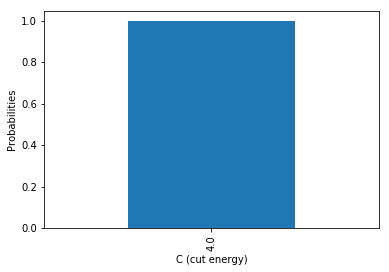

In [48]:
plot_samples(results_dwave)
plot_energies(results_dwave)

<Figure size 432x288 with 0 Axes>

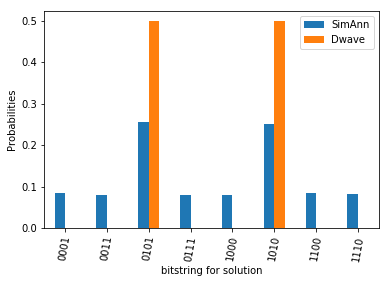

In [49]:
samples_simann = [''.join(c for c in str(datum.sample.values()).strip(', ') if c.isdigit()) for datum in results_simann.data(['sample'],sorted_by=None)]
samples_dwave = [''.join(c for c in str(datum.sample.values()).strip(', ') if c.isdigit()) for datum in results_dwave.data(['sample'],sorted_by=None)]
    
counts_simann = Counter(samples_simann)
total_simann = len(samples_simann)
for key in counts_simann:
    counts_simann[key] /= total_simann
df1 = pd.DataFrame.from_dict(counts_simann, orient='index', columns=['SimAnn']).sort_index()

counts_dwave = Counter(samples_dwave)
total_dwave = len(samples_dwave)
for key in counts_simann:
    counts_dwave[key] /= total_dwave
df2 = pd.DataFrame.from_dict(counts_dwave, orient='index', columns=['Dwave']).sort_index()
df = pd.concat([df1,df2], axis=1)
plt.figure()
df.plot(kind='bar')

plt.xticks(rotation=80)
plt.xlabel('bitstring for solution')
plt.ylabel('Probabilities')
plt.show()

<Figure size 432x288 with 0 Axes>

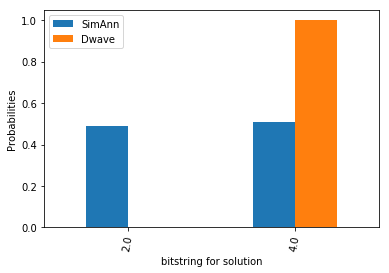

In [50]:
energies_simann = [-datum.energy for datum in results_simann.data(['energy'],sorted_by=None)]
energies_dwave = [-datum.energy for datum in results_dwave.data(['energy'],sorted_by=None)]
    
counts_simann = Counter(energies_simann)
total_simann = len(energies_simann)
for key in counts_simann:
    counts_simann[key] /= total_simann
df1 = pd.DataFrame.from_dict(counts_simann, orient='index', columns=['SimAnn']).sort_index()

counts_dwave = Counter(energies_dwave)
total_dwave = len(energies_dwave)
for key in counts_dwave:
    counts_dwave[key] /= total_dwave
df2 = pd.DataFrame.from_dict(counts_dwave, orient='index', columns=['Dwave']).sort_index()
df = pd.concat([df1,df2], axis=1)
plt.figure()
df.plot(kind='bar')

plt.xticks(rotation=80)
plt.xlabel('bitstring for solution')
plt.ylabel('Probabilities')
plt.show()

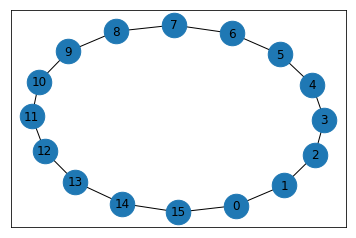

In [15]:
G2 = nx.cycle_graph(16)

# Generate plot of the Graph
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G2)

nx.draw_networkx(G2, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [35]:
bqm = ising_maxcut(G2)
start_time = timeit.default_timer()
results_exact = exact_sampler.sample(bqm)
time_exact = timeit.default_timer() - start_time
print("The time it took to enumerate of all solutions was "+str(time_exact)+" seconds")

The time it took to enumerate of all solutions was 0.44863230000009935 seconds


In [36]:
start_time = timeit.default_timer()
results_simann = sim_ann.sample(bqm, num_reads=2048)
time_simann = timeit.default_timer() - start_time
print("The time it took 2048 runs of simmulated annealing was "+str(time_simann)+" seconds")

The time it took 2048 runs of simmulated annealing was 0.5695462000003317 seconds


<Figure size 432x288 with 0 Axes>

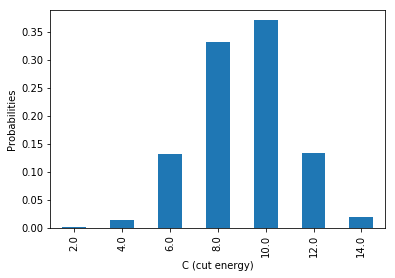

In [37]:
# plot_samples(results_simann)
plot_energies(results_simann)

In [38]:
start_time = timeit.default_timer()
results_dwave = sampler.sample(bqm, num_reads=2048)
time_dwave = timeit.default_timer() - start_time

In [39]:
print("The total time it took 2048 runs of quantum annealing was "+str(time_dwave)+" seconds")
time_dwave_detailed = results_dwave.info["timing"]
for key, value in time_dwave_detailed.items():
    print(str(key) + ' = ' + str(value/1000000) + " seconds")

The total time it took 2048 runs of quantum annealing was 2.5157261000003928 seconds
qpu_sampling_time = 0.645038 seconds
qpu_anneal_time_per_sample = 2e-05 seconds
qpu_readout_time_per_sample = 0.000274 seconds
qpu_access_time = 0.654411 seconds
qpu_access_overhead_time = 0.0042 seconds
qpu_programming_time = 0.009373 seconds
qpu_delay_time_per_sample = 2.1e-05 seconds
post_processing_overhead_time = 0.000224 seconds
total_post_processing_time = 0.00046 seconds
total_real_time = 0.654411 seconds
run_time_chip = 0.645038 seconds
anneal_time_per_run = 2e-05 seconds
readout_time_per_run = 0.000274 seconds


<Figure size 432x288 with 0 Axes>

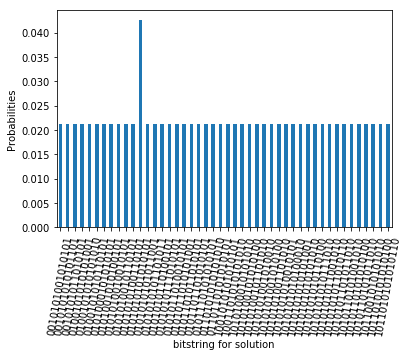

<Figure size 432x288 with 0 Axes>

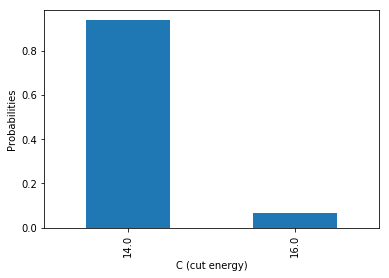

In [40]:
plot_samples(results_dwave)
plot_energies(results_dwave)

<Figure size 432x288 with 0 Axes>

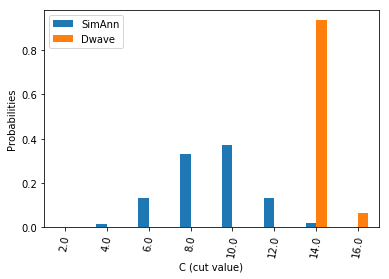

In [43]:
energies_simann = [-datum.energy for datum in results_simann.data(['energy'],sorted_by=None)]
energies_dwave = [-datum.energy for datum in results_dwave.data(['energy'],sorted_by=None)]
    
counts_simann = Counter(energies_simann)
total_simann = len(energies_simann)
for key in counts_simann:
    counts_simann[key] /= total_simann
df1 = pd.DataFrame.from_dict(counts_simann, orient='index', columns=['SimAnn']).sort_index()

counts_dwave = Counter(energies_dwave)
total_dwave = len(energies_dwave)
for key in counts_dwave:
    counts_dwave[key] /= total_dwave
df2 = pd.DataFrame.from_dict(counts_dwave, orient='index', columns=['Dwave']).sort_index()
df = pd.concat([df1,df2], axis=1)
plt.figure()
df.plot(kind='bar')

plt.xticks(rotation=80)
plt.xlabel('C (cut value)')
plt.ylabel('Probabilities')
plt.show()

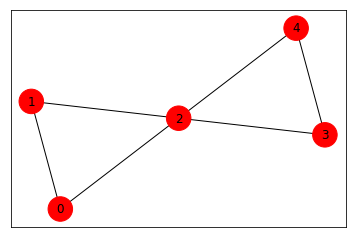

In [51]:
# Generating the butterfly graph with 5 nodes 
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

The time it takes the enumeration of all solutions was 0.0020816000005652313 seconds


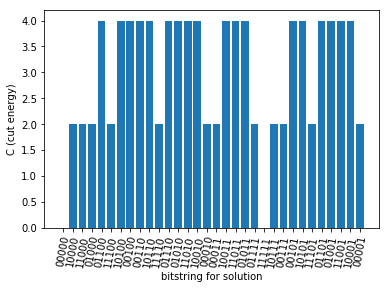

In [52]:
bqm = ising_maxcut(G)
start_time = timeit.default_timer()
results_exact = exact_sampler.sample(bqm)
time_exact = timeit.default_timer() - start_time
print("The time it takes the enumeration of all solutions was "+str(time_exact)+" seconds")
plot_ennumerate(results_exact)

The time it took 2048 runs of simmulated annealing was 0.18136750000030588 seconds


<Figure size 432x288 with 0 Axes>

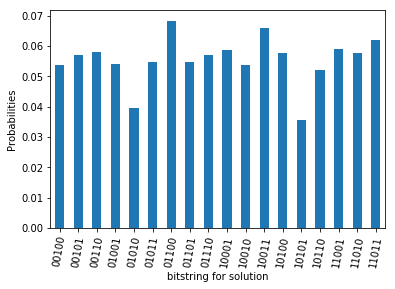

<Figure size 432x288 with 0 Axes>

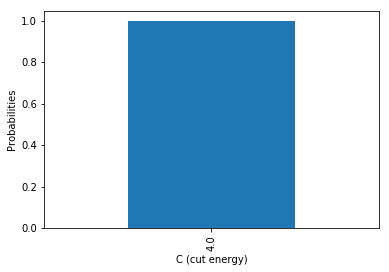

In [53]:
start_time = timeit.default_timer()
results_simann = sim_ann.sample(bqm, num_reads=2048)
time_simann = timeit.default_timer() - start_time
print("The time it took 2048 runs of simmulated annealing was "+str(time_simann)+" seconds")
plot_samples(results_simann)
plot_energies(results_simann)

In [54]:
start_time = timeit.default_timer()
results_dwave = sampler.sample(bqm, num_reads=2048)
time_dwave = timeit.default_timer() - start_time

In [55]:
print("The total time it took 2048 runs of quantum annealing was "+str(time_dwave)+" seconds")
time_dwave_detailed = results_dwave.info["timing"]
for key, value in time_dwave_detailed.items():
    print(str(key) + ' = ' + str(value/1000000) + " seconds")

The total time it took 2048 runs of quantum annealing was 2.1301242999998067 seconds
qpu_sampling_time = 0.645038 seconds
qpu_anneal_time_per_sample = 2e-05 seconds
qpu_readout_time_per_sample = 0.000274 seconds
qpu_access_time = 0.654398 seconds
qpu_access_overhead_time = 0.003578 seconds
qpu_programming_time = 0.00936 seconds
qpu_delay_time_per_sample = 2.1e-05 seconds
post_processing_overhead_time = 0.000781 seconds
total_post_processing_time = 0.002704 seconds
total_real_time = 0.654398 seconds
run_time_chip = 0.645038 seconds
anneal_time_per_run = 2e-05 seconds
readout_time_per_run = 0.000274 seconds


<Figure size 432x288 with 0 Axes>

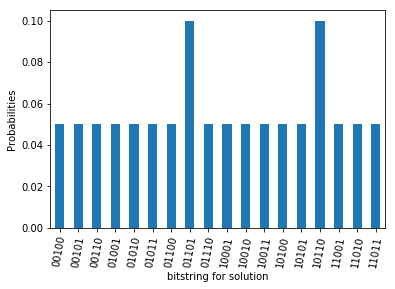

<Figure size 432x288 with 0 Axes>

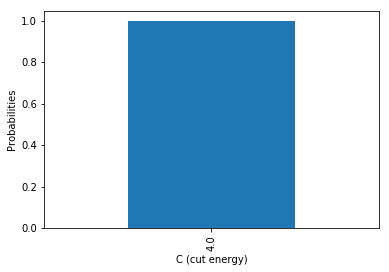

In [56]:
plot_samples(results_dwave)
plot_energies(results_dwave)

c:\users\debernal\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<Figure size 432x288 with 0 Axes>

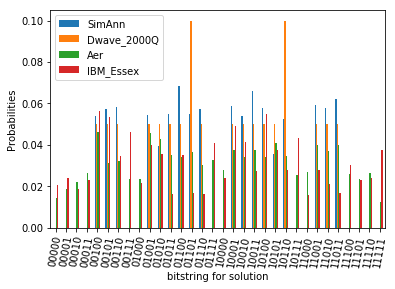

In [60]:
samples_simann = [''.join(c for c in str(datum.sample.values()).strip(', ') if c.isdigit()) for datum in results_simann.data(['sample'],sorted_by=None)]
samples_dwave = [''.join(c for c in str(datum.sample.values()).strip(', ') if c.isdigit()) for datum in results_dwave.data(['sample'],sorted_by=None)]
    
counts_simann = Counter(samples_simann)
total_simann = len(samples_simann)
for key in counts_simann:
    counts_simann[key] /= total_simann
df1 = pd.DataFrame.from_dict(counts_simann, orient='index', columns=['SimAnn']).sort_index()

counts_dwave = Counter(samples_dwave)
total_dwave = len(samples_dwave)
for key in counts_dwave:
    counts_dwave[key] /= total_dwave
df2 = pd.DataFrame.from_dict(counts_dwave, orient='index', columns=['Dwave_2000Q']).sort_index()
df12 = pd.concat([df1,df2], axis=1)
plt.figure()
df.plot(kind='bar')

counts_qiskit = {'10001': 77, '11100': 53, '11000': 55, '01110': 62, '10010': 70, '01010': 88, '11011': 82, '00010': 45, '00011': 54, '00110': 66, '00100': 95, '00101': 64, '00000': 29, '10011': 77, '11111': 25, '10110': 71, '11101': 48, '00001': 38, '10100': 70, '01000': 48, '10101': 84, '11110': 54, '01011': 72, '00111': 48, '11010': 76, '10000': 57, '11001': 82, '01100': 70, '10111': 52, '01101': 75, '01001': 94, '01111': 67}
for key in counts_qiskit:
    counts_qiskit[key] /= 2048
df3 = pd.DataFrame.from_dict(counts_qiskit, orient='index', columns=['Aer']).sort_index()
df123 = pd.concat([df12,df3], axis=1)

counts_ibm = {'10001': 101, '11100': 62, '11000': 32, '01110': 33, '10010': 85, '01010': 73, '11011': 34, '00010': 38, '00011': 47, '00110': 71, '00100': 115, '00101': 109, '00000': 42, '10011': 56, '11111': 77, '10110': 57, '11101': 47, '00001': 49, '10100': 112, '01000': 44, '10101': 77, '11110': 49, '01011': 33, '00111': 95, '11010': 43, '10000': 49, '11001': 57, '01100': 72, '10111': 89, '01101': 34, '01001': 82, '01111': 84}
for key in counts_ibm:
    counts_ibm[key] /= 2048
df4 = pd.DataFrame.from_dict(counts_ibm, orient='index', columns=['IBM_Essex']).sort_index()
df = pd.concat([df123,df4], axis=1)

plt.xticks(rotation=80)
plt.xlabel('bitstring for solution')
plt.ylabel('Probabilities')
plt.show()

<Figure size 432x288 with 0 Axes>

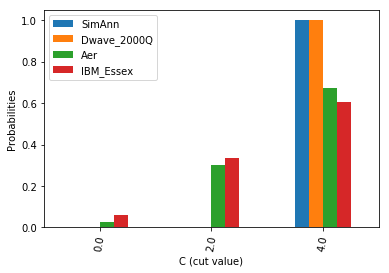

In [61]:
energies_simann = [-datum.energy for datum in results_simann.data(['energy'],sorted_by=None)]
energies_dwave = [-datum.energy for datum in results_dwave.data(['energy'],sorted_by=None)]
    
counts_simann = Counter(energies_simann)
total_simann = len(energies_simann)
for key in counts_simann:
    counts_simann[key] /= total_simann
df1 = pd.DataFrame.from_dict(counts_simann, orient='index', columns=['SimAnn']).sort_index()

counts_dwave = Counter(energies_dwave)
total_dwave = len(energies_dwave)
for key in counts_dwave:
    counts_dwave[key] /= total_dwave
df2 = pd.DataFrame.from_dict(counts_dwave, orient='index', columns=['Dwave_2000Q']).sort_index()
df12 = pd.concat([df1,df2], axis=1)

counts_qiskit = {4.0: 0.67138671875, 2.0: 0.30224609375, 0.0: 0.0263671875}
df3 = pd.DataFrame.from_dict(counts_qiskit, orient='index', columns=['Aer']).sort_index()
df123 = pd.concat([df12,df3], axis=1)

counts_ibm = {4.0: 0.607421875, 2.0: 0.33447265625, 0.0: 0.05810546875}
df4 = pd.DataFrame.from_dict(counts_ibm, orient='index', columns=['IBM_Essex']).sort_index()
df = pd.concat([df123,df4], axis=1)

plt.figure()
df.plot(kind='bar')

plt.xticks(rotation=80)
plt.xlabel('C (cut value)')
plt.ylabel('Probabilities')
plt.show()

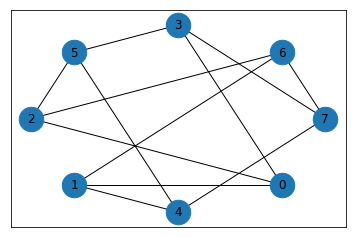

In [30]:
Eex = [(7, 6),(7, 3),(5, 3),(6, 2),(6, 1),(5, 2),(7, 4),(3, 0),(1, 0),(4, 1),(5, 4),(2, 0)]
Gex     = nx.Graph()
Gex.add_edges_from(Eex)

# Generate plot of the Graph
default_axes = plt.axes(frameon=True)
pos          = nx.circular_layout(Gex)

nx.draw_networkx(Gex, node_size=600, alpha=1, ax=default_axes, pos=pos)

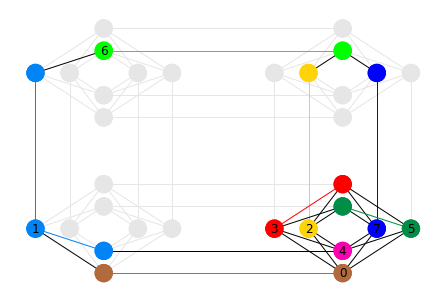

In [31]:
X = dnx.chimera_graph(2, 2)
h_embed = mm.find_embedding(Gex, X)
dnx.draw_chimera_embedding(X, h_embed, show_labels=True)